### Diplom thesis
- vyzkouset/najit spravnou **architekturu neuronove site** (LSTM 2-3 vnitrni vrstvy, droup out vyzkouset, zmensovani velikosti vrstev, hyperopt, pouzit Keras?)
- **optimalizace parametru** neuronove site
- provest **uceni neuronove site** (to mozna nechat na konec, provest 20x-30x beh nebo cross validaci -> zprumerovat? at je to pouzitelne ono to vychazi dost ruzne)

In [1]:
# keras module for building LSTM 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku 
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow
from keras import models 
# from tensorflow.keras.layers import Input, Embedding, LSTM, 

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

import pandas as pd
import numpy as np
import string, os 
import math
from matplotlib import pyplot as plt

import ast
from tensorflow.keras.preprocessing.sequence import pad_sequences
import itertools
from functools import partial

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
from hyperopt.pyll.base import scope 
from hyperopt import pyll, hp, Trials, fmin, tpe, STATUS_OK
# from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasRegressor 
# import scikeras
# from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import pickle
import os

# Load data

### BPE
- list tokens id

In [2]:
# df = pd.read_csv('../data/VEGF2_ChEMBL28_tokenizationBPE_oneHotEncoding_listTokensIds_cutListTokensIds.csv',sep=',')
# df.head(2)

### Statistika
- jak vypadaji hodnoty biologicke aktivity (jaky rozsah - priblizit hodnotu RMSE)

### Tvorba dat

In [3]:
# # n_features = 1
# RANDOM_STATE=42
# limit =20
# ys = df['value'][:limit]
# # col_names = ['canonical_smiles_tokenIndexList','sln_tokenIndexList','deep_smiles_tokenIndexList','selfies_tokenIndexList','inchi_tokenIndexList']

# # zatim zkusim jen jeden chem lin zapis
# col_names = ['canonical_smiles']
# list_tokens = []

# for col_name in col_names:
#     print(col_name)
#     res = df[col_name+'_tokenIndexList'].apply(lambda x: returnVector(x))
#     # print(res.tolist()[0])
#     [print (i) for i in res.tolist()[:3]]
#     [print (i) for i in res.tolist()[-3:]]
#     print(len(res[0]))
#     vector_with_padding = pad_sequences(res, maxlen=len(res[0]), padding='post', truncating='post')
#     print(vector_with_padding[0])
#     # tf.convert_to_tensor(res)
#     # res = res.tolist()
#     # res = df[col_name].apply(lambda tokens_ids: ast.literal_eval(tokens_ids))
#     list_tokens.append(vector_with_padding)
#     # print(res)
#     print('\n')
#     print(vector_with_padding)

# print(type(list_tokens[0][1]))

# Trenovani neuronove site

In [2]:
def showPlot(history,linearNotation_name,modelLossPlot_name):
    # plot training history
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss - '+linearNotation_name)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.savefig(modelLossPlot_name)
    # plt.show()

### Pomocne funkce

In [3]:
# kontrola, rozdeleni data tak je vzdy stejne i kdyz pouziji data pro jiny chem. lin. zapis
def splitData(idx, list_token, ys, RANDOM_STATE):  
    # smiles ulozeni tokenu pro smiles
    X_train, X_test, y_train, y_test = train_test_split(list_token, ys, test_size=0.2, random_state=RANDOM_STATE)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE) # 0.25 x 0.8 = 0.2
    t_w= len(np.unique(list(itertools.chain.from_iterable(X_train))))
    
    return X_train,y_train,X_val,y_val,X_test,y_test,t_w

In [4]:
# nacteny list tokenu prevedu na list a pak pomoci pad_sequence na validni vstup do neuronove site
def createListToken(df, RANDOM_STATE, limit, col_names):  
    list_tokens = []

    for col_name in col_names:
        res = df[col_name+'_tokenIndexList'].apply(lambda x: ast.literal_eval(x))
        vector_with_padding = pad_sequences(res, maxlen=len(res[0]), padding='post', truncating='post')
        list_tokens.append(vector_with_padding) 
    return list_tokens

In [35]:
# vytvoreni modelu s tunnenim parametru
def create_model(units_embedding,units1,units2,units3, layers, rate1,rate2,rate3, max_length, vocab_size):
    n_features = 1
    # tady je treba to nastavit podle nejvyssiho indexu, jinak embedding vyhodi chybu
    vocab_size=vocab_size+10000
    # Keras LSTM model
    model = Sequential()
    model.add(Embedding(vocab_size, units_embedding, input_length=max_length))
#     if layers == 1:
#         model.add(LSTM(units=units1, input_shape=(max_length, n_features) ))
#         model.add(Dropout(rate=rate1))
#     else:
        # First layer specifies input_shape and returns sequences
    model.add(LSTM(units=units1, return_sequences=True, input_shape=(max_length, n_features)))
    model.add(Dropout(rate=rate1))

    # Middle layers return sequences
    for i in range(layers-2):
        model.add(LSTM(units=units2, return_sequences=True))
        model.add(Dropout(rate=rate2))

    # Last layer doesn't return anything
    model.add(LSTM(units=units3))
    model.add(Dropout(rate=rate3))

    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam',metrics=['mse'])
    return model

In [36]:
# objective funkce pro hyperopt s cross validaci
def objective(params, list_token, n_patience, idx, max_length,vocab_size,X_train,y_train):
    es = EarlyStopping(monitor='loss', mode='min', verbose=0, patience=n_patience)
    
    model_nn = KerasRegressor(build_fn = create_model,**params, max_length=max_length,vocab_size=vocab_size,  epochs = 400, verbose = 0)
    kfold = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
    score_m = cross_val_score(model_nn, X_train, y_train,scoring='neg_mean_squared_error', cv=kfold,fit_params={'callbacks':[es]},error_score='raise').mean()
    loss = -score_m
    print('\nscore:\n',loss)
    print('params:\n',params)
    # Dictionary with information for evaluation
    return {
        'loss': loss,
        'params': params,
        'status': STATUS_OK }

In [37]:
def builtModelParams(params,max_length,list_token,j, vocab_size):
    n_features = 1
    vocab_size=vocab_size+10000
    # Keras LSTM model
    model = Sequential()
    model.add(Embedding(vocab_size, params['units_embedding'], input_length=max_length))

    # if layers == 1:
    #     model.add(LSTM(units=params['units'], input_shape=(max_length, n_features) ))
    #     model.add(Dropout(rate=params['rate']))
    # else:
        # First layer specifies input_shape and returns sequences
    model.add(LSTM(units=params['units1'], return_sequences=True, input_shape=(max_length, n_features)))
    model.add(Dropout(rate=params['rate1']))

    # Middle layers return sequences
    for i in range(params['layers']-2):
        model.add(LSTM(units=params['units2'], return_sequences=True))
        model.add(Dropout(rate=params['rate2']))

    # Last layer doesn't return anything
    model.add(LSTM(units=params['units3']))
    model.add(Dropout(rate=params['rate3']))

    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam',metrics=['mse'])
    return model

In [44]:
def plotPredictReal(predictions,y_test,tokenization,chem_notation,fileNameEncoding):
        plt.figure(figsize=(10,10))
        plt.scatter(y_test, predictions, c='crimson')
        p1 = max(max( predictions), max(y_test))
        p2 = min(min( predictions), min(y_test))
        plt.plot([p1, p2], [p1, p2], 'b-')
        plt.title(tokenization+'_'+chem_notation, fontsize=15)
        plt.xlabel('True Values', fontsize=15)
        plt.ylabel('Predictions', fontsize=15)
        plt.axis('equal')
        plt.show
        plt.savefig('../data/models/'+fileNameEncoding+'/predictions_'+tokenization+'_'+chem_notation+'.png')

# Novy pokus a spravne


bpe
chem notation:   canonical_smiles
                                                     
score:

0.96996321273399                                     
params:                                              

{'layers': 2, 'rate1': 0.11695302548420733, 'rate2': 0.06712870390571762, 'rate3': 0.14546594628839932, 'units1': 45, 'units2': 120, 'units3': 30, 'units_embedding': 105}
                                                                              
score:

1.049944282567423                                                             
params:                                                                       

{'layers': 2, 'rate1': 0.3380958708858408, 'rate2': 0.25457880813652395, 'rate3': 0.41506604915774303, 'units1': 50, 'units2': 55, 'units3': 15, 'units_embedding': 15}
                                                                              
score:

1.0501759032471978                                                            
params:                                

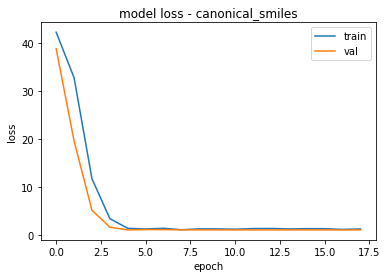

chem notation:   sln
                                                     
score:

0.9641339556180754                                   
params:                                              

{'layers': 3, 'rate1': 0.13347645342762127, 'rate2': 0.011560160523319984, 'rate3': 0.34927683781734387, 'units1': 75, 'units2': 110, 'units3': 105, 'units_embedding': 20}
                                                                                
score:

0.9663596177400853                                                              
params:                                                                         

{'layers': 2, 'rate1': 0.23283819098003272, 'rate2': 0.03515774620147227, 'rate3': 0.16740121786750262, 'units1': 40, 'units2': 35, 'units3': 30, 'units_embedding': 30}
                                                                                
score:

0.97675549650466                                                                
params:                                      

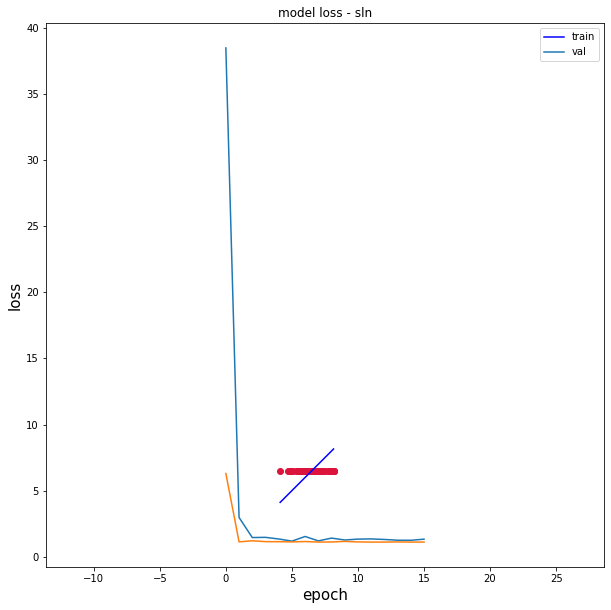

chem notation:   deep_smiles
                                                     
score:

0.97141190879136                                     
params:                                              

{'layers': 2, 'rate1': 0.08185305576717106, 'rate2': 0.10437810952195054, 'rate3': 0.1695827782162186, 'units1': 110, 'units2': 55, 'units3': 70, 'units_embedding': 75}
                                                                              
score:

0.9280064083274494                                                            
params:                                                                       

{'layers': 2, 'rate1': 0.11260388473949184, 'rate2': 0.16320465615894159, 'rate3': 0.4911321962750335, 'units1': 45, 'units2': 75, 'units3': 65, 'units_embedding': 80}
                                                                                
score:

0.9754918604175913                                                              
params:                                        

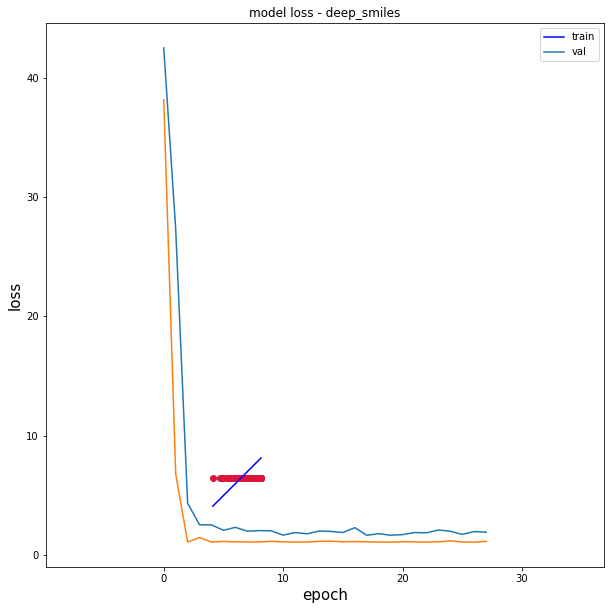

chem notation:   selfies
                                                     
score:

0.9727553231445452                                   
params:                                              

{'layers': 2, 'rate1': 0.2329594286939103, 'rate2': 0.2579750888941827, 'rate3': 0.18013229653136492, 'units1': 10, 'units2': 85, 'units3': 20, 'units_embedding': 10}
                                                                                
score:

0.9699714405954042                                                              
params:                                                                         

{'layers': 2, 'rate1': 0.24594023189400582, 'rate2': 0.11746528063258699, 'rate3': 0.14964520099277362, 'units1': 95, 'units2': 100, 'units3': 100, 'units_embedding': 65}
                                                                                
score:

0.9678421698529232                                                              
params:                                     

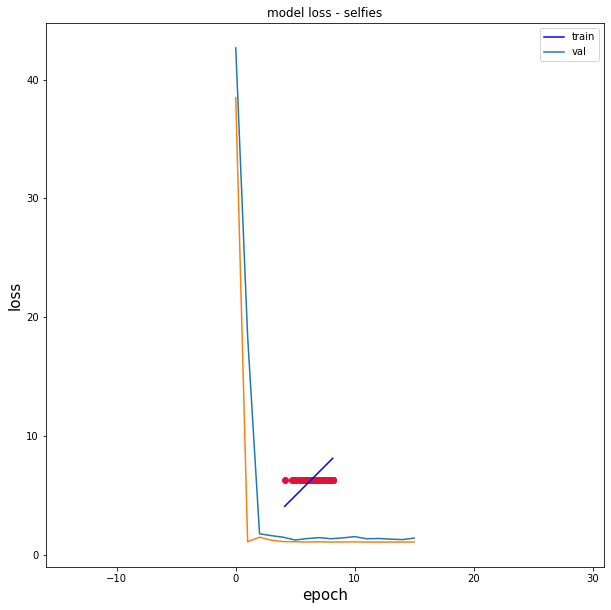

chem notation:   inchi
                                                     
score:

0.9877353082969128                                   
params:                                              

{'layers': 2, 'rate1': 0.22578770651892488, 'rate2': 0.4085862101517598, 'rate3': 0.4367323848040471, 'units1': 90, 'units2': 55, 'units3': 110, 'units_embedding': 55}
                                                                                
score:

0.9799690758497246                                                              
params:                                                                         

{'layers': 3, 'rate1': 0.4891698021666568, 'rate2': 0.39921506590244404, 'rate3': 0.2184251474521836, 'units1': 50, 'units2': 110, 'units3': 85, 'units_embedding': 100}
                                                                                
score:

0.9697735858422074                                                              
params:                                        

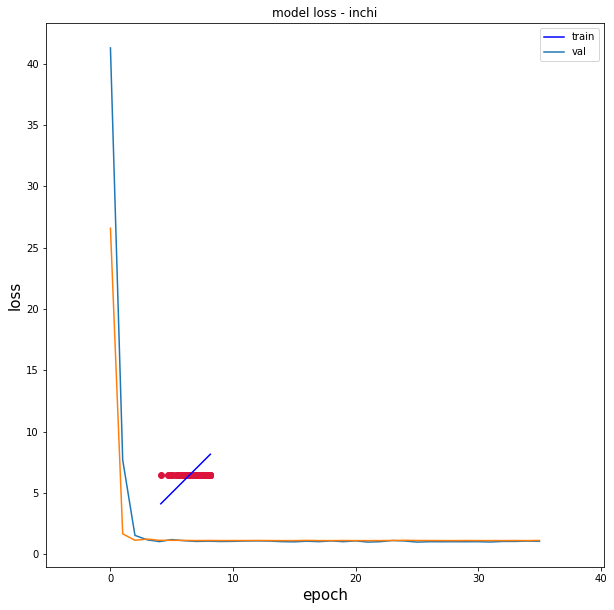


atom
chem notation:   canonical_smiles
                                                     
score:

1.0031750108270696                                   
params:                                              

{'layers': 2, 'rate1': 0.32667327675296004, 'rate2': 0.26551017309291863, 'rate3': 0.47384622044259417, 'units1': 120, 'units2': 120, 'units3': 60, 'units_embedding': 45}
                                                                                
score:

0.9795506837680218                                                              
params:                                                                         

{'layers': 2, 'rate1': 0.29196014487116967, 'rate2': 0.11231708502937127, 'rate3': 0.19908436445832312, 'units1': 90, 'units2': 45, 'units3': 50, 'units_embedding': 105}
                                                                                
score:

0.996951674473911                                                               
params:                   

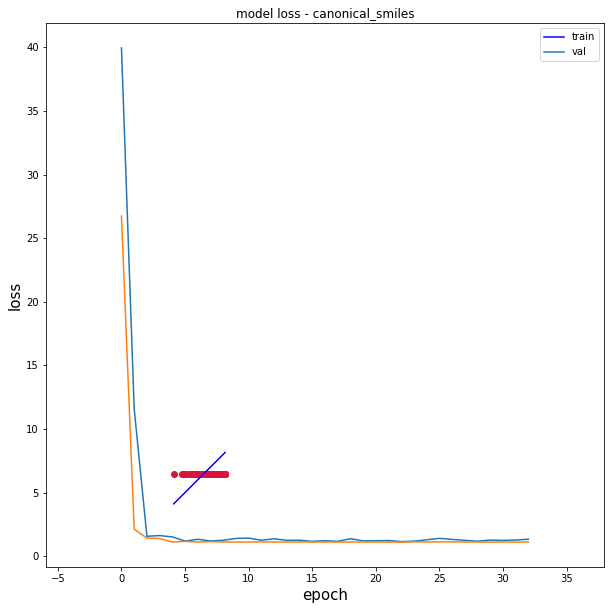

chem notation:   sln
                                                     
score:

0.9740960343952386                                   
params:                                              

{'layers': 3, 'rate1': 0.1017477888822097, 'rate2': 0.3349179183381769, 'rate3': 0.10656796688436321, 'units1': 115, 'units2': 80, 'units3': 110, 'units_embedding': 85}
                                                                                
score:

0.9993046405096282                                                              
params:                                                                         

{'layers': 3, 'rate1': 0.3014175039268345, 'rate2': 0.03000870559679958, 'rate3': 0.3870785933052518, 'units1': 40, 'units2': 30, 'units3': 25, 'units_embedding': 110}
                                                                                
score:

0.9661194448177242                                                              
params:                                          

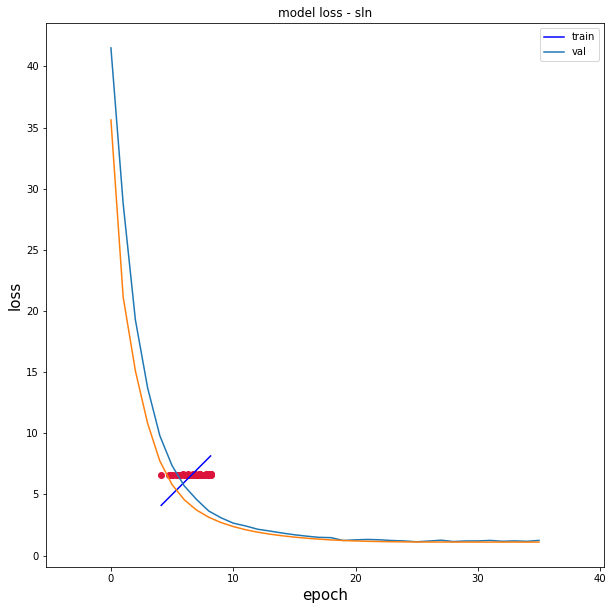

chem notation:   deep_smiles
                                                     
score:

0.9677573138567951                                   
params:                                              

{'layers': 3, 'rate1': 0.1692946566235205, 'rate2': 0.21534451210998606, 'rate3': 0.2988996535477679, 'units1': 95, 'units2': 80, 'units3': 95, 'units_embedding': 40}
                                                                                
score:

0.9758946611002821                                                              
params:                                                                         

{'layers': 2, 'rate1': 0.24092320076899054, 'rate2': 0.40752938979472925, 'rate3': 0.49048729655657747, 'units1': 40, 'units2': 40, 'units3': 70, 'units_embedding': 45}
                                                                                
score:

0.9354971383755292                                                              
params:                                   

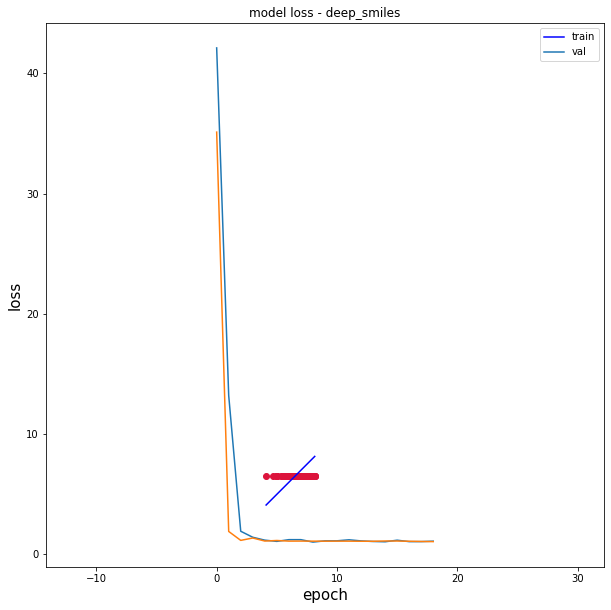

chem notation:   selfies
                                                     
score:

0.9767163593682098                                   
params:                                              

{'layers': 3, 'rate1': 0.293018531786524, 'rate2': 0.18953323863346772, 'rate3': 0.03265358116635203, 'units1': 50, 'units2': 105, 'units3': 50, 'units_embedding': 10}
                                                                                
score:

0.9805286456562359                                                              
params:                                                                         

{'layers': 3, 'rate1': 0.409243456464147, 'rate2': 0.1640004820111916, 'rate3': 0.26949788031546323, 'units1': 115, 'units2': 15, 'units3': 100, 'units_embedding': 15}
                                                                                
score:

1.0087108912867335                                                              
params:                                       

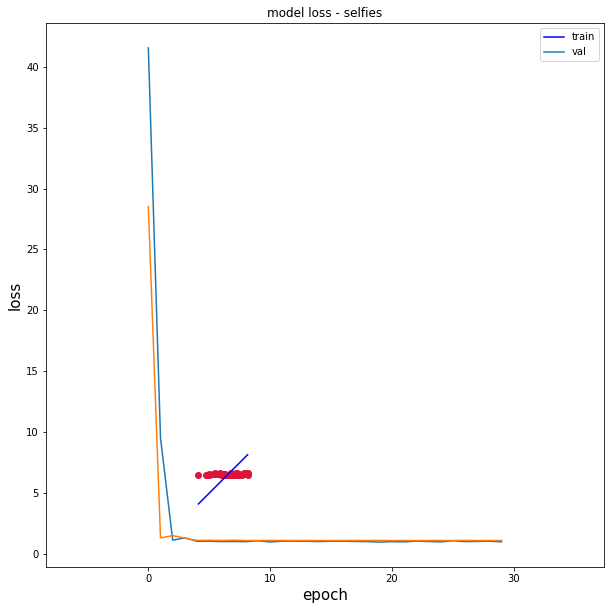

chem notation:   inchi
                                                     
score:

0.9706774178514612                                   
params:                                              

{'layers': 3, 'rate1': 0.4008024816844561, 'rate2': 0.4634827388796008, 'rate3': 0.10424425777667623, 'units1': 70, 'units2': 15, 'units3': 20, 'units_embedding': 75}
                                                                                 
score:

0.981444996624856                                                                
params:                                                                          

{'layers': 3, 'rate1': 0.15884193192759044, 'rate2': 0.4192745281454936, 'rate3': 0.19601637945695144, 'units1': 10, 'units2': 115, 'units3': 65, 'units_embedding': 35}
                                                                                 
score:

0.9743630361392009                                                               
params:                                    

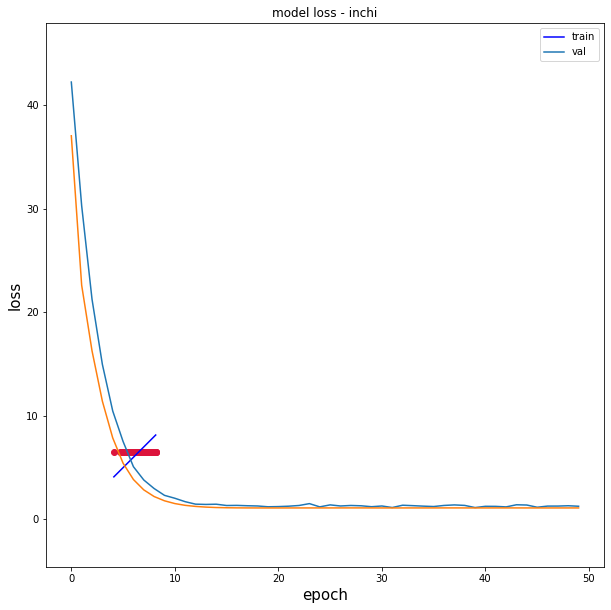


char
chem notation:   canonical_smiles
                                                     
score:

0.9951564900867051                                   
params:                                              

{'layers': 3, 'rate1': 0.2544508176757343, 'rate2': 0.3190177381939237, 'rate3': 0.4771887567578969, 'units1': 30, 'units2': 95, 'units3': 110, 'units_embedding': 110}
                                                                                
score:

0.9824225313952857                                                              
params:                                                                         

{'layers': 3, 'rate1': 0.034775223435119795, 'rate2': 0.20694126527640722, 'rate3': 0.3513906061183428, 'units1': 15, 'units2': 15, 'units3': 45, 'units_embedding': 80}
                                                                                
score:

0.968236897633135                                                               
params:                       

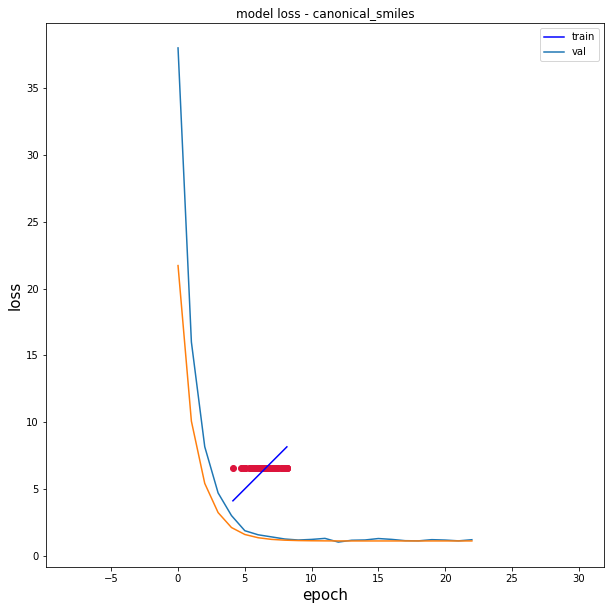

chem notation:   sln
                                                     
score:

0.9700423619156883                                   
params:                                              

{'layers': 3, 'rate1': 0.4909365572319288, 'rate2': 0.22966319957482373, 'rate3': 0.354859102201371, 'units1': 70, 'units2': 120, 'units3': 65, 'units_embedding': 85}
                                                                                
score:

0.9680038802463589                                                              
params:                                                                         

{'layers': 2, 'rate1': 0.2227695691001647, 'rate2': 0.30711942704803635, 'rate3': 0.12805234861366233, 'units1': 65, 'units2': 75, 'units3': 95, 'units_embedding': 50}
                                                                                
score:

0.9781745197253231                                                              
params:                                            

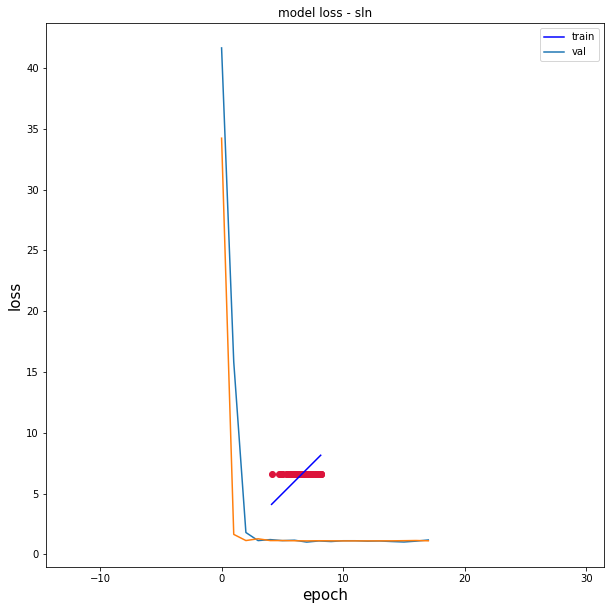

chem notation:   deep_smiles
                                                     
score:

1.036483494474992                                    
params:                                              

{'layers': 2, 'rate1': 0.0914048228024093, 'rate2': 0.2751437072631708, 'rate3': 0.4318241267516638, 'units1': 105, 'units2': 110, 'units3': 20, 'units_embedding': 15}
                                                                               
score:

0.9559047295278533                                                             
params:                                                                        

{'layers': 2, 'rate1': 0.10247295650315202, 'rate2': 0.4781157720565754, 'rate3': 0.1670957971661216, 'units1': 100, 'units2': 120, 'units3': 45, 'units_embedding': 80}
                                                                                
score:

1.3776890422353674                                                              
params:                                     

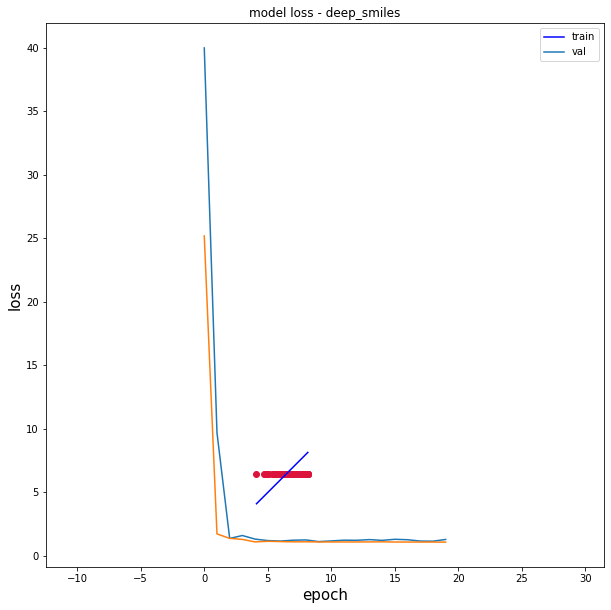

chem notation:   selfies
                                                     
score:

0.9839126804534898                                   
params:                                              

{'layers': 2, 'rate1': 0.025750470351061427, 'rate2': 0.1415830141726584, 'rate3': 0.10755615998504464, 'units1': 10, 'units2': 35, 'units3': 90, 'units_embedding': 90}
                                                                                 
score:

0.9737628466111643                                                               
params:                                                                          

{'layers': 2, 'rate1': 0.22340315556964307, 'rate2': 0.06348550665792069, 'rate3': 0.03720655744615997, 'units1': 40, 'units2': 40, 'units3': 70, 'units_embedding': 30}
                                                                                 
score:

0.9755144946304652                                                                 
params:                              

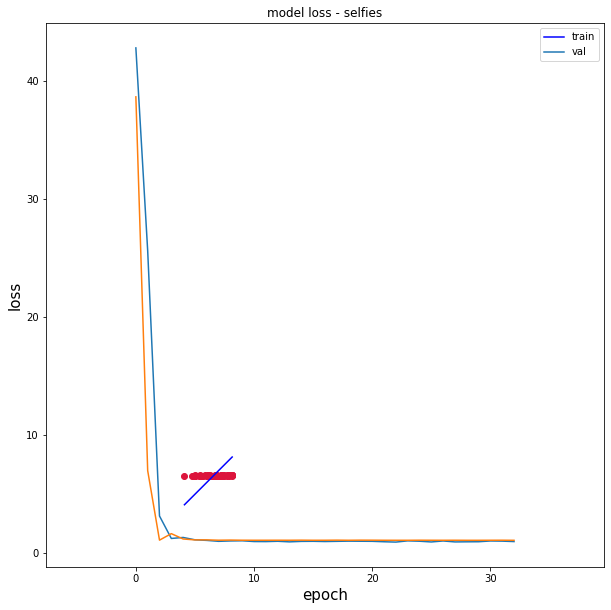

chem notation:   inchi
                                                     
score:

0.9773575270885851                                   
params:                                              

{'layers': 3, 'rate1': 0.25661836428570295, 'rate2': 0.4805822130555772, 'rate3': 0.307233401558002, 'units1': 20, 'units2': 105, 'units3': 25, 'units_embedding': 85}
                                                                                
score:

0.9713535565605167                                                              
params:                                                                         

{'layers': 2, 'rate1': 0.1308204074800542, 'rate2': 0.1803384580035141, 'rate3': 0.47798754127237597, 'units1': 110, 'units2': 30, 'units3': 70, 'units_embedding': 75}
 67%|██████▋   | 2/3 [30:15<14:59, 899.36s/trial, best loss: 0.9713535565605167]

In [ ]:
# zkontrolovat, jestli se jedna os pravny chemicky linearni zapis

tokenization_names = ['bpe','atom','char','spe','kmer']
fileName_tokenization = ['../data/VEGF2_ChEMBL28_tokenizationBPE_oneHotEncoding_listTokensIds_cutListTokensIds.csv',
                         '../data/VEGF2_ChEMBL28_tokenizationAtomLevel_oneHotEncoding_listTokensIds_cutListTokensIds.csv',
                         '../data/VEGF2_ChEMBL28_tokenizationCharacterLevel_oneHotEncoding_listTokensIds_cutListTokensIds.csv',
                         '../data/VEGF2_ChEMBL28_tokenizationSPE_oneHotEncoding_listTokensIds_cutListTokensIds.csv',
                         '../data/VEGF2_ChEMBL28_tokenizationKmer_listTokensIds_cutListTokensIds.csv',
                        ]

linearNotation_names = ['canonical_smiles','sln','deep_smiles','selfies','inchi']

df_score = {'tokenization': ['empty'], 'chem_notation': ['empty'],'score_cross_val':['empty']}
df_score = pd.DataFrame(df_score)

fileNameEncoding = 'tokenIndexVec'
fileNameScore = '../data/models/'+fileNameEncoding+'/scoreCrossVal.csv'
# As file at filePath is deleted now, so we should check if file exists or not not before deleting them
if os.path.exists(fileNameScore):
    os.remove(fileNameScore)
df_score.to_csv(fileNameScore,sep=',',header=True,index=False)

m_e=3
n_patience = 10
RANDOM_STATE=42
limit =400

space = {'rate1'              : hp.uniform('rate1',0.00,0.5),
         'rate2'              : hp.uniform('rate2',0.00,0.5),
         'rate3'              : hp.uniform('rate3',0.00,0.5),
         'units1'             : scope.int(hp.quniform('units1',10,120,5)),
         'units2'             : scope.int(hp.quniform('units2',10,120,5)),
         'units3'             : scope.int(hp.quniform('units3',10,120,5)),
         'units_embedding'    : scope.int(hp.quniform('units_embedding',10,120,5)),
         'layers'             : scope.int(hp.quniform('layers',2,3,1))}


# lengths_lst_tokenIdxs = {'spe':[11]}
lengths_lst_tokenIdxs = {
    'atom':[62,105,70,65,170],
    'char':[65,113,65,320,175],
    'kmer':[62,105,62,62,165],
    'bpe':[30,65,25,120,120],
    'spe':[14,11,10,35,40]}

for i in range(len(tokenization_names)):
    tokenization = tokenization_names[i]
    df_score['tokenization'][0] = tokenization
    print('\n'+tokenization)
    df = pd.read_csv(fileName_tokenization[i],sep=',')
    
    ys = df['value'][:limit]
    list_tokens = createListToken(df, RANDOM_STATE, limit, linearNotation_names)
    
    for j in range(len(linearNotation_names)):
        chem_notation = linearNotation_names[j] 
        df_score['chem_notation'][0] = chem_notation
        print('chem notation:  ',chem_notation)
        
        bestModel_name = '../data/models/'+fileNameEncoding+'/bestModel_'+tokenization+'_'+chem_notation+'.h5'
        modelHistory_name = '../data/models/'+fileNameEncoding+'/history_'+tokenization+'_'+chem_notation+'.npy'
        modelLossPlot_name = '../data/models/'+fileNameEncoding+'/modelLossPlot_'+tokenization+'_'+chem_notation+'.png'
        best_paramsNameFile = '../data/models/'+fileNameEncoding+'/bestParams_'+tokenization+'_'+chem_notation+'.pkl'
        predictionsNameFile = '../data/models/'+fileNameEncoding+'/predictions_'+tokenization+'_'+chem_notation+'prediction.csv'
        
        # j je chemicky linearni zapis, limit je # radku kolik vezmeme (pro vyzkouseni beru jen 20)
        list_token = list_tokens[j][:limit]
        max_length=lengths_lst_tokenIdxs[tokenization][j]
        X_train,y_train,X_val,y_val,X_test,y_test,t_w = splitData(j, list_token, ys, RANDOM_STATE)

        # zatim mam jen chemicke linearni zapisy
        fmin_objective = partial(objective,list_token=list_token, n_patience =  n_patience,idx=j,vocab_size = t_w ,max_length = max_length,X_train=X_train,y_train=y_train)
        
        bayes_trials = Trials()
        best = fmin(fn = fmin_objective, space = space, algo = tpe.suggest, max_evals = m_e, trials = bayes_trials)#, rstate = np.random.RandomState(50))

        best_loss = bayes_trials.results[np.argmin([r['loss'] for r in bayes_trials.results])]['loss']
        best_params = bayes_trials.results[np.argmin([r['loss'] for r in bayes_trials.results])]['params']
        print('best params:\n',best_params,'\nbest loss:\n',best_loss,end = '\n')
    
        df_score['score_cross_val'][0] = best_loss
        df_score.to_csv(fileNameScore, mode='a', index=False, header=False)
        # print(df_score)
        # print(df_score.iloc[0])
        # df_score.drop(df_score.iloc[0])
        
        # create model (with best parametres)
        # (best_params,max_length,list_token,j,vocab_size
        m = builtModelParams(best_params,max_length,list_token,j,t_w)
        
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=n_patience)
        # train model
        result = m.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=400, verbose=0, callbacks=[es])
        # model prediction
        y_pred = m.predict(X_test)
        
        showPlot(result,chem_notation,modelLossPlot_name)
        
        #store information
        #   best model
        m.save(bestModel_name)
        
        #   history
        with open(modelHistory_name, 'w') as f:
            np.save(modelHistory_name,result.history)
        
        # best params
        a_file = open(best_paramsNameFile, "wb")
        pickle.dump(best_params, a_file)
        a_file.close()
        
        # # predictions
        prediction = pd.DataFrame(y_pred, columns=['predictions']).to_csv(predictionsNameFile)
        plotPredictReal(y_pred, y_test,tokenization,chem_notation,fileNameEncoding)

In [ ]:
for i in range(len(tokenization_names)):
    tokenization = tokenization_names[i]
    ys = df['value'][:limit]
    
    for j in range(len(linearNotation_names)):
        chem_notation = linearNotation_names[j]
        
        best_paramsNameFile = '../data/models/'+fileNameEncoding+'/bestParams_'+tokenization+'_'+chem_notation+'.pkl'

        a_file = open(best_paramsNameFile, "rb")
        output = pickle.load(a_file)
        print(output)
        print(type(best_params))

In [ ]:
df = pd.read_csv(fileNameScore,sep=',')
df

In [ ]:
# {'layers': 2, 'rate1': 0.11695302548420733, 'rate2': 0.06712870390571762, 'rate3': 0.14546594628839932, 'units1': 45, 'units2': 120, 'units3': 30, 'units_embedding': 105}

In [ ]:
lengths_lst_tokenIdxs = {
    'atom':[62,105,70,65,170],
    'char':[65,113,65,320,175],
    'kmer':[62,105,62,62,165],
    'bpe':[30,65,25,120,120],
    'spe':[14,11,10,35,40] }

tokenization = 'bpe'
# m_e=3
n_patience = 10
RANDOM_STATE=42
j=0
# limit =400
print('\n'+tokenization)
df = pd.read_csv('../data/VEGF2_ChEMBL28_tokenizationBPE_oneHotEncoding_listTokensIds_cutListTokensIds.csv',sep=',')

ys = df['value']#[:limit]
linearNotation_names = ['canonical_smiles']#,'sln','deep_smiles','selfies','inchi']
list_tokens = createListToken(df, RANDOM_STATE, limit, linearNotation_names)

chem_notation = 'canonical_smiles' 
# j je chemicky linearni zapis, limit je # radku kolik vezmeme (pro vyzkouseni beru jen 20)
list_token = list_tokens[j]#[:limit]
max_length=lengths_lst_tokenIdxs[tokenization][j]
X_train,y_train,X_val,y_val,X_test,y_test,t_w = splitData(j, list_token, ys, RANDOM_STATE)

best_params = {'layers': 2, 'rate1': 0.11695302548420733, 'rate2': 0.06712870390571762, 'rate3': 0.14546594628839932, 'units1': 45, 'units2': 120, 'units3': 30, 'units_embedding': 105}
m = builtModelParams(best_params,max_length,list_token,j,t_w)

es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=n_patience)
# train model
result = m.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=400, verbose=0, callbacks=[es])
# model prediction
y_pred = m.predict(X_test)

showPlot(result,chem_notation,modelLossPlot_name)

plotPredictReal(y_pred, y_test,tokenization,chem_notation,fileNameEncoding)